In [1]:
#import packages and formatting statements

import numpy as np
import math
# !pip install matplotlib
from matplotlib import pyplot as plt
# !pip install astropy==5.3
import astropy.io.fits as pyfits
from astropy.table import Table, join, Column
from astropy.wcs import WCS
from astropy.io import ascii
import os
from astropy.coordinates import SkyCoord, Angle
from astropy.nddata import Cutout2D
import astropy.units as u
from astropy.visualization.wcsaxes import SphericalCircle
from matplotlib.patches import Circle
from reproject import reproject_interp

import sys
sys.path.append('./Python')
from CheckInImage import check_in_image
from AngularSize import findAngSize

plt.rc('text',usetex=False)
fontsize=10
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

ext=0

In [2]:
# Compile galaxy and sne data
data = Table.read('../Data/1.GroupedSampleData.csv', format='csv')

data[0:1]

col0,galaxy,distance,gal_ra,gal_dec,pos_ang,incl,nat_res,r_eff,maps_musedap,maps_nat,maps_150,maps_1kpc,maps_HII,maps_irac,maps_CO21,maps_eCO21,maps_ext,maps_vdisp,maps_HST,sn_name,sn_type,sn_ra,sn_dec
int64,str7,float64,float64,float64,float64,float64,float64,float64,str71,str58,str64,str63,str50,str40,str72,str73,str36,str32,str45,str82,str50,str127,str132
0,NGC1087,15.85,41.60492,-0.498717,359.1,42.9,0.92,42.091877,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1087-0.92asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr_150pc.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr_1kpc.fits,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2.fits,../Data/IRAC/ngc1087_irac1_atGauss4.fits,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_co21_150pc_broad_emom0.fits,../Data/SFR_v1/NGC1087_MAPS_sfr.fits,../Data/vdisp/ngc1087_vdisp.fits,../../GalaxyFiles/HST/ngc1087_hst_ha_sic.fits,['SN1995V'],['II'],[41.61152777777777],[-0.4987861111111111]


In [3]:
# get plot information for main image maps for the zooms
def getPlotStuff(gal, img, res, HIIimg, CO21Img, eCO21Img, names, types, ras, decs, dist, ext):
    plots, sigma, wcss, HIImaps, hdus, dists, resolution = [],[],[],[],[],[],[]
    SNnames, SNtypes, SNras, SNdecs, SNgals, inHII = [],[],[],[],[],[]

    for i in range(len(gal)):
        print(gal[i])
        # ungroup and clean SN data
        sn_ra   = [float(x.strip(' []')) for x in ras[i].split(',')]
        sn_dec  = [float(x.strip(' []')) for x in decs[i].split(',')]
        sn_name = [x.strip(' []') for x in names[i].split(',')]
        sn_type = [x.strip(' []') for x in types[i].split(',')]
        
        for j in range(len(sn_name)):
            
            if os.path.isfile(img[i]) and os.path.isfile(HIIimg[i]):

                #get hdu & wcs for MAIN IMAGE map
                ha_hdu = pyfits.open(img[i])
                hdus.append(ha_hdu)
                ha_map = ha_hdu[ext].data
                w = WCS(ha_hdu[ext].header, naxis=2)
                wcss.append(w)                
                plots.append(ha_map)
                resolution.append(res[i])
                
                #get HII maps
                hii_hdu = pyfits.open(HIIimg[i])
                hii_map, footprint = reproject_interp(hii_hdu, ha_hdu[ext].header)
                HIImaps.append(hii_map)
                                
                # get CO contour map 
                if gal[i][0] == "NGC1672":
                    co_img = "../../GalaxyFiles/ALMACO2-1/ngc1672_7m+tp_co21_750pc_broad_mom0.fits"
                    co_err = "../../GalaxyFiles/ALMACO2-1/ngc1672_7m+tp_co21_750pc_broad_emom0.fits"
                else:
                    co_img = CO21Img[i]
                    co_err = eCO21Img[i]
                        
                co_hdu = pyfits.open(co_img)
                eco_hdu = pyfits.open(co_err)

                # reproject onto Halpha map
                co_repro_hdu, footprint = reproject_interp(co_hdu, ha_hdu[ext].header)
                eco_repro_hdu, footprint = reproject_interp(eco_hdu, ha_hdu[ext].header)

                # set up CO21 s/n map 
                co_map = co_repro_hdu
                err_map = eco_repro_hdu
                err_map = np.clip(err_map,0.01,np.max(err_map))
                sig_map = co_map / err_map
                sigma.append(sig_map)

                        
                # get rest of data
                SNnames.append(sn_name[j])
                SNtypes.append(sn_type[j])
                SNras.append(sn_ra[j]) 
                SNdecs.append(sn_dec[j])
                SNgals.append(gal[i])
                dists.append(dist[i])
                
#                 #Check if SN is in HII region
#                 w_hii = WCS(hii_hdu[ext].header, naxis=2)
#                 xval, yval = w_hii.wcs_world2pix(sn_ra[j],sn_dec[j], 0)
#                 xVal = int(xval)
#                 yVal = int(yval)
#                 HIIval = hii_map[yVal, xVal]

#                 if HIIval < 0:
#                     inHII.append("No ")
#                 else:
#                     inHII.append("Yes ")

            else:
                #print("no file for ")
                pass

    return(plots, sigma, wcss, HIImaps, hdus, SNnames, SNtypes, SNras, SNdecs, SNgals, dists, resolution)


In [4]:
# set up plot information for HST zooms
# set up plots, wcs information, and HII maps for contours.

plots, sigma, wcss, HIImaps, hdus, sn_names, sn_types, sn_ras, sn_decs, sn_gals, dists, res = getPlotStuff(data["galaxy"], data["maps_HST"], data["nat_res"], data["maps_HII"], data["maps_CO21"], data["maps_eCO21"], data["sn_name"], data["sn_type"], data["sn_ra"], data["sn_dec"], data["distance"], ext)


NGC1087
NGC1300
NGC1365
NGC1433
NGC1566
NGC1672
NGC3627
NGC4254
NGC4303
NGC4321


In [5]:

resPC = [71,82,109,109,109,109,82,69,69,69,90,90,58,58,58,58,58,57,57,57,57,64,64,64,64,64,64,64,85,85,85,85,85]
len(resPC)

#set up labels for legends
legendLabels = []

for i in range(len(sn_names)):
    legendlabel = []
    if sn_types[i][0] == 'unclassified':
        legendlabel.append(sn_names[i].strip("'") + ' '  + sn_types[i].strip("'")) 
    else:        
        legendlabel.append(sn_names[i].strip("'") + ' Type '  + sn_types[i].strip("'"))
    legendLabels.append(legendlabel)

# print(legendLabels[0])


/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_54253/4271602612.py:28: RuntimeWarning: invalid value encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_54253/4271602612.py:28: RuntimeWarning: invalid value encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_54253/4271602612.py:28: RuntimeWarning: invalid value encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_54253/4271602612.py:28: RuntimeWarning: invalid value encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_54253/4271602612.py:28: RuntimeWarning: invalid value encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_54253/4271602612.py:28: RuntimeWarning: invalid value encountered in log10
  logData = np.log10(data)
/Users/nessmaykerchen/anaconda3/li

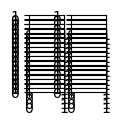

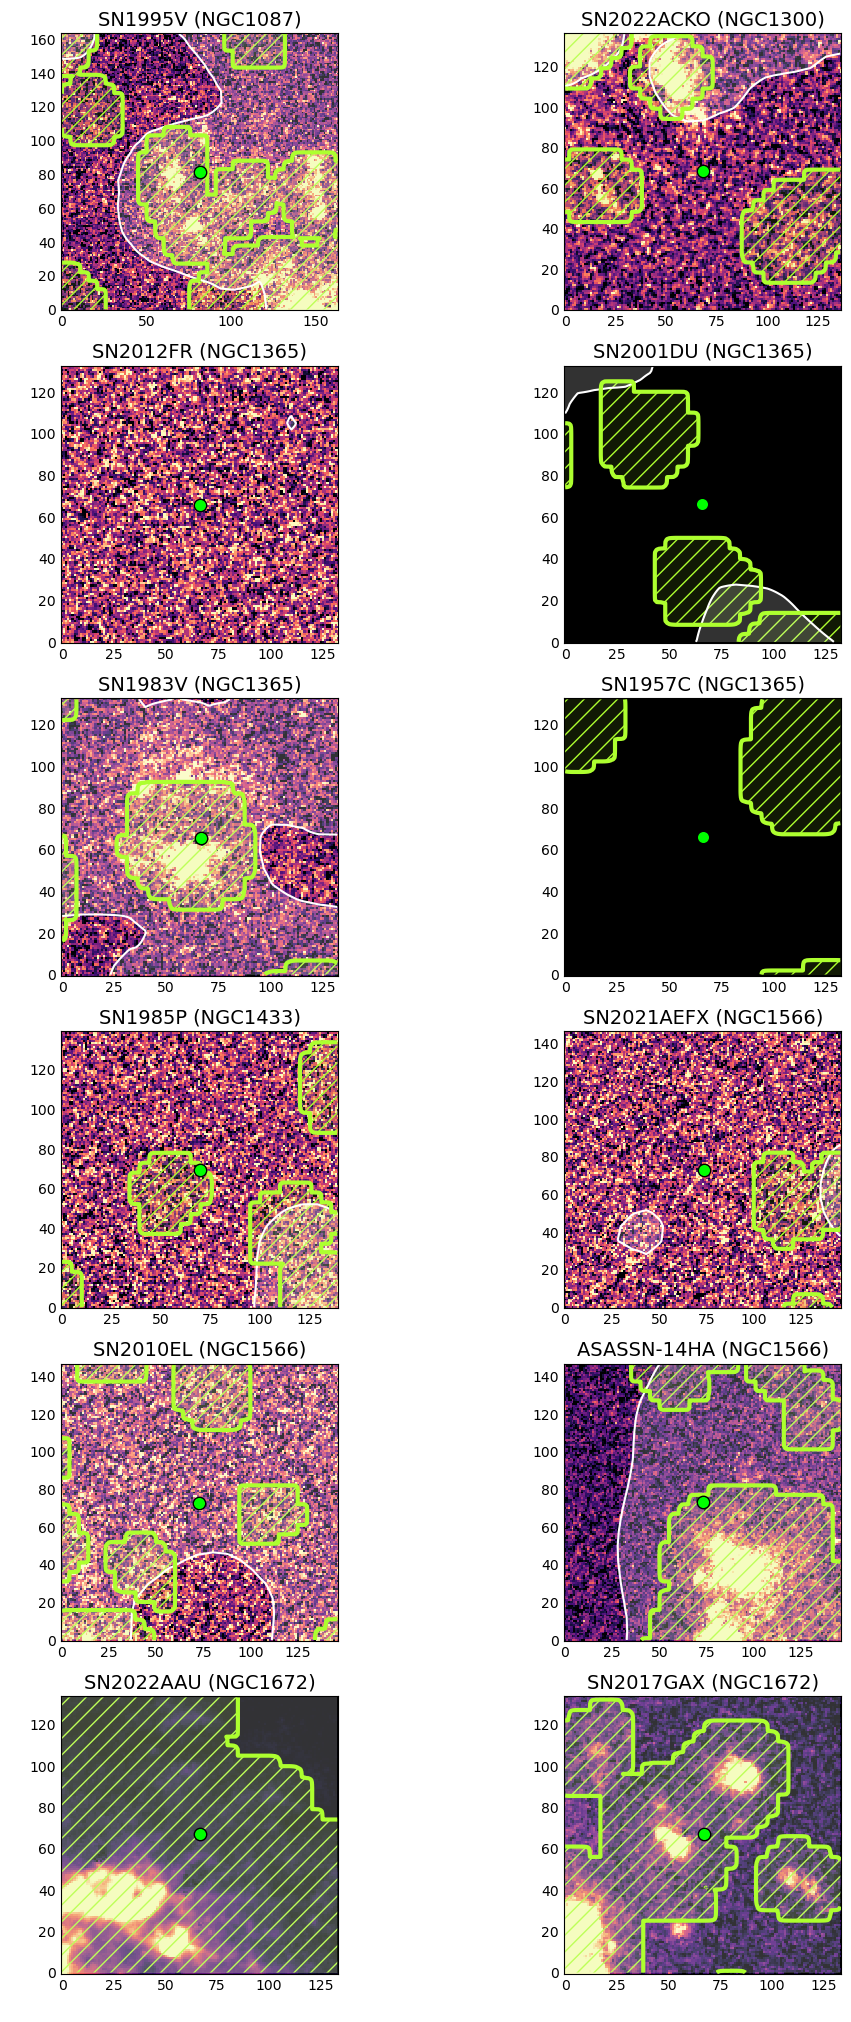

In [8]:
plt.rcParams['hatch.color'] = 'greenyellow'
numPixels, numHIIPixels = [],[]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

NUM_SNE= 33
# halfBox = 0.00416667 # 15'' in degrees

m,n,p = 0,0,0 # plot counters for total number, rows, columns
PLOTS_PER_ROW = 2

fig2, axs = plt.subplots(math.ceil(NUM_SNE/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(1, 1))
fig = plt.figure(figsize = (10,70))

for j in range(len(sn_gals)): # counter to count galaxy maps
    if hasattr(plots, "__len__"):

        #set up legend label with type classification
        if sn_types[j] != "Unclassified":
            leglab = "Type " + sn_types[j].strip("'")#+ ": " + inHII[j]
        else:
            leglab= sn_types[j]# + ": " + inHII[j]
        legStr = str(resPC[j]) + " pc"

        #set up data to use astropy's cutout2D to plot subsections of galaxy map
        data = plots[j]
        logData = np.log10(data)
        HIIData = HIImaps[j]
        sigData = sigma[j]

        wcs=wcss[j]

        halfBox = findAngSize(500,dists[j])/2. # 500 pc in decimal degrees/2?
        #cutout2D needs skycoord position to carry units
        ra, dec = Angle(sn_ras[j] * u.degree), Angle(sn_decs[j] * u.degree)
        raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad    
        position = SkyCoord(raRad, decRad) #position is center, use ra & dec of SN location
        size = u.Quantity((findAngSize(500,dists[j]),findAngSize(500,dists[j])), u.degree) #size is size of box in arcsec 
        # make 2D cutout, will assign a new wcs to cutout to keep track of coords
        cutout = Cutout2D(data, position, size, wcs) 
        # use this new wcs when converting to pixels to add additional details to plot
        xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
        # get HII data for contours
        HIICutout = Cutout2D(HIIData, position, size, wcs)
        sigCutout = Cutout2D(sigData, position, size, wcs)

        titleStr = sn_names[j].upper().strip("'") + " (" + sn_gals[j].upper() + ")"
        # make plot
        axs[m][n] = fig.add_subplot(17, 2, p+1)#, projection = cutout.wcs)   # astropy and matplotlib/python incompatible now
        axs[m][n].set_title(titleStr, fontsize=14)            
        axs[m][n].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", vmin=np.percentile(cutout.data, 5), vmax=np.percentile(cutout.data, 95),interpolation = "nearest", zorder = 0)
        axs[m][n].scatter(xval, yval, color = "black", marker ="o", s = 60, zorder=2)
        axs[m][n].scatter(xval, yval, color = "lime", marker = "o", s = 80, edgecolor="black",zorder = 2, label=leglab)
        axs[m][n].set_ylabel(" ")
        axs[m][n].set_xlabel(" ")
        axs[m][n].tick_params(axis = "both", direction = "in", length = 0)

    #     # plot HST data if available
    #     if hasattr(HSTmaps[j], "__len__"):
    #         HSTdata = HSTmaps[j]
    #         HSTcutout = Cutout2D(HSTdata, position, size, wcs)
    #         axs[m][n].imshow(HSTcutout.data, cmap=current_cmap, aspect="equal", origin = "lower", vmin=np.percentile(HSTcutout.data, 5), vmax=np.percentile(HSTcutout.data, 95),interpolation = "nearest", zorder = 0, alpha=1.0)

        plt.rcParams['hatch.color'] = 'greenyellow'

        axs[m][n].contourf(HIICutout.data, [3,1000000], colors = ["greenyellow"], linestyles = ("-"), hatches=['//'], zorder = 1, alpha=0.1)
        axs[m][n].contourf(sigCutout.data, [3,1000000], colors = ["white"], linestyles = ("-"), zorder = 1, alpha = 0.2)
        axs[m][n].contour(sigCutout.data, [3], colors = ["white"], linestyles = ("-"),  zorder = 1)
        axs[m][n].contour(HIICutout.data, [3], colors = ["greenyellow"], linestyles = ("-"), linewidths=3, zorder = 1)

        # add in second legend to say resolution
#         resLeg = axs[m][n].legend([legStr],handlelength=0, handletextpad=0,loc="upper right", facecolor='white', framealpha=1.0)
#         for item in resLeg.legendHandles:
#             item.set_visible(False)
#         axs[m][n].add_artist(resLeg)

#         leg = axs[m][n].legend(handlelength=0, handletextpad=0, loc="lower left", facecolor='white', framealpha=1.0)
#         for item in leg.legendHandles:
#             item.set_visible(False)

        n+=1
        if n%PLOTS_PER_ROW==0:
            m+=1
            n=0
        p +=1

        plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.99, top = 0.9, wspace = 0.3, hspace = 0.2)
#plt.tight_layout(pad=0.5, w_pad=6.8, h_pad=1.0)
plt.show()
fig.savefig("../Figures/HST_Zooms_500pc.png", dpi=300)
plt.close()